In [36]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import scipy.misc
import pickle
%matplotlib inline

In [37]:
%run Utils.py

In [38]:
#Discriminator class. Assumes 64x64 inputs.
class DiscNet(torch.nn.Module):
    def __init__(self, in_dim, out_dim, ndf = 128, ngpu = 1):
        super(DiscNet, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.ndf = ndf
        self.ngpu = ngpu
        
        self.conv = nn.Sequential(
            #Start with (N x 1 x input_size x input_size) 64
            nn.Conv2d(self.in_dim, self.ndf, 4, 2, 1),
            nn.LeakyReLU(0.2),
            #Gives me (N x ndf x input_size//2 x input_size//2) 32
            nn.Conv2d(self.ndf, self.ndf*2, 4, 2, 1),
            nn.BatchNorm2d(self.ndf*2),
            nn.LeakyReLU(0.2),
            #Then have N x 2*ndf x input_size//4 x input_size//4 16
            nn.Conv2d(self.ndf*2, self.ndf*4, 4, 2, 1),
            nn.BatchNorm2d(self.ndf*4),
            nn.LeakyReLU(0.2),
            #Now have N x 4*ndf x input_size//8 x input_size//8 8
            nn.Conv2d(self.ndf*4, self.ndf*8, 4, 2, 1),
            nn.BatchNorm2d(self.ndf*8),
            nn.LeakyReLU(0.2),
        )
        self.last = nn.Sequential(
            #Now N x 8*ndf x input_size//16 x input_size//16 (128 x 1024 x 4 x 4)
            nn.Conv2d(self.ndf*8, self.out_dim, 4, 1, 0),
            nn.Sigmoid()
            #Output N x out_dim x 
        )
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, inp):
        x = self.conv(inp)
#         print(x.size())
        x = self.last(x)
        return x

    

In [39]:
#Generator class. Assumes 64x64 outputs.
class GenNet(torch.nn.Module):
    def __init__(self, in_dim, out_dim, ngf = 128, ngpu = 1):
        super(GenNet, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.ngf = ngf
        self.ngpu = ngpu
        
        self.conv = nn.Sequential(
            #start with latent dimensional input
            nn.ConvTranspose2d(self.in_dim, 8*self.ngf, 4, 1, 0),
            nn.BatchNorm2d(8*self.ngf),
            nn.ReLU(),
            #100 x 8*ngf x 2 x 2
            nn.ConvTranspose2d(8*self.ngf, 4 * self.ngf, 4, 2, 1),
            nn.BatchNorm2d(4*self.ngf),
            nn.ReLU(),
            #Now 100 x 4*ngf x 4 x 4
            nn.ConvTranspose2d(4*self.ngf, 2*self.ngf, 4, 2, 1),
            nn.BatchNorm2d(2*self.ngf),
            nn.ReLU(),
            #Now 100 x 2*ngf x 8 x 8
            nn.ConvTranspose2d(2*self.ngf, self.ngf, 4, 2, 1),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(),
            #Now 100 x ngf x 16 x 16
            nn.ConvTranspose2d(self.ngf, self.out_dim, 4, 2, 1),
            nn.Tanh()
            #Output 100 x out_dim (num_channels) x 32 x 32 images.
        )
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, inp):
        return self.conv(inp)

In [40]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [47]:
#GAN class container.
class GAN(object):
    def __init__(self):
        start_time = time.time()
        
        self.num_epochs = 30
        self.batch_size = 256
        self.image_size = 64
        self.z_dim = 128
        self.ndf = 128
        self.ngf = 128
        self.lr = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.999
        
        self.ngpu = 1
        #With num_workers=2, takes 0.5 secs per minibatch --> ~60s per 25 minibatches on 1st epoch.
        #with num_workes = 8, takes 0.5 s per minibatch --> ~12s per 25 minibatches. MUCH faster loop.
        #Above #s working with 64 ngf and ndf. With 128 ngf and ndf:
        #With num_workers = 8, takes 1.9 s per minibatch --> ~50s per 25 minibatches. Approx 25 min per epoch.
        self.workers = 8
        self.dataset = 'CelebA'
        self.save_dir = 'models/'
        self.result_dir = 'results/'
        self.model_name = 'DCGAN'
        self.sample_num = 25
        
#         print("Initialized variables at {}".format(time.time() - start_time))
        
        #NOTE: Change the normalization if not using MNIST.
        trans = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.CenterCrop(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])
        
        self.data_loader = torch.utils.data.DataLoader(
            datasets.ImageFolder(root = "./data/{}".format(self.dataset), transform = trans),
            batch_size = self.batch_size,
            shuffle = True,
            num_workers = self.workers
        )
#         print("Loaded data at {}s".format(time.time() - start_time))
        
#         self.num_channels = next(iter(self.data_loader))[0].size()[1]
        self.num_channels = 1 if self.dataset == 'MNIST' else 3
#         print("Got num_channels at {}s".format(time.time() - start_time))
        
        self.device = torch.device("cuda:0" if (torch.cuda.is_available() and self.ngpu >0) else "cpu")
        
        self.D = DiscNet(in_dim = self.num_channels, out_dim = 1, ndf = self.ndf , ngpu = self.ngpu).to(self.device)
#         print("Created D at {}s".format(time.time() - start_time))
        self.G = GenNet(in_dim = self.z_dim, out_dim = self.num_channels, ngf = self.ngf, ngpu = self.ngpu).to(self.device)
#         print("Creaed G at {}s".format(time.time() - start_time))
                
        self.criterion = nn.BCELoss().to(self.device)
        self.sample_z = torch.randn(self.batch_size, self.z_dim, 1, 1, device = self.device)
        
        if (self.device.type == 'cuda') and (self.ngpu > 1):
            self.G = nn.DataParallel(self.G, list(range(self.ngpu)))
            self.D = nn.DataParallel(self.D, list(range(self.ngpu)))
        
        self.G.weight_init(mean=0., std= 0.02)
        self.D.weight_init(mean=0., std= 0.02)
        
        self.D_optimizer = optim.Adam(self.D.parameters(), lr = self.lr, betas = (self.beta1, self.beta2))
        self.G_optimizer = optim.Adam(self.G.parameters(), lr = self.lr, betas = (self.beta1, self.beta2))

        
    def plot_train(self):
        real_batch = next(iter(self.data_loader))
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.title("Training Images")
        plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(self.device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['per_epoch_time'] = []
        self.train_hist['total_time'] = []
        
        real_label = 1
        fake_label = 0
        
        start_time = time.time()
        
        for epoch in range(self.num_epochs):
            
            epoch_start_time = time.time()
            
            for i, (x, _) in enumerate(self.data_loader, 0):
                batch_start_time = time.time()
#                 print("Took {} to do enumerate".format(batch_start_time - epoch_start_time))
                
                #TRAIN D
                self.D.zero_grad()
                
                s = time.time()

                b_size = x.size()[0]
#                 print("Getting batch size loss took {}s. Total time {}".format(time.time() - s, time.time() - batch_start_time))

                x = Variable(x.to(self.device))
                y_real = Variable(torch.ones(b_size, device = self.device))
                y_fake = Variable(torch.zeros(b_size, device = self.device))
                
                output = self.D(x).view(-1)
                D_real_loss = self.criterion(output, y_real)
                del output
                        
                noise = Variable(torch.randn(b_size, self.z_dim, 1, 1, device = self.device))
                fake = self.G(noise)
                output = self.D(fake).view(-1)
                del noise
                del fake
                

                D_fake_loss = self.criterion(output, y_fake)
                #.11 s fake loss. Already took 5s to gt to this point. bottleneck probably above.

                del output
                            
                D_loss = D_real_loss + D_fake_loss
                del D_real_loss
                del D_fake_loss
                
                self.train_hist['D_loss'].append(D_loss.item())
                
                D_loss.backward()
                self.D_optimizer.step()
                del D_loss
                
                #Train G
                self.G.zero_grad()
                noise = Variable(torch.randn(b_size, self.z_dim, 1, 1, device = self.device))
                fake = self.G(noise)
                del noise
                
                output = self.D(fake).view(-1)
                del fake
                
                G_loss = self.criterion(output, y_real)
                del output
                
                G_loss.backward()
                self.G_optimizer.step()
                
                self.train_hist['G_loss'].append(G_loss.item())
                
                if i%25 == 0:
                    print("Completed minibatch {} in {}; epoch since {}".format(i+1, time.time() - batch_start_time, time.time() - epoch_start_time))
                
            self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
                
            self.train_hist['total_time'].append(time.time() - start_time)
            with torch.no_grad():
                self.visualize_results((epoch+1))
            print("Completed epoch {} in {}".format(epoch+1, time.time() - epoch_start_time))
        
        print("Done Training!")
        self.save()
        
        
        generate_animation('{}/{}/{}/{}'.format(self.result_dir, self.dataset, self.model_name, self.model_name),
                                 self.num_epochs)
        loss_plot(self.train_hist, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)
        
        
    def visualize_results(self, epoch, fix=True):
        self.G.eval()
        
        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)
            
        tot_num_samples = min(self.sample_num, self.batch_size)
        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
        
        samples = self.G(self.sample_z)
        
        if self.ngpu>0:
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)
            
        samples = (samples + 1)/2
        
        
        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], 
                    [image_frame_dim, image_frame_dim],
        '{}/{}/{}/{}_epoch{:03}.png'.format(self.result_dir, self.dataset, self.model_name, self.model_name, epoch))
        
    
    def save(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)
        
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        torch.save(self.G.state_dict(), os.path.join(save_dir, self.model_name + '_G.pkl'))
        torch.save(self.D.state_dict(), os.path.join(save_dir, self.model_name + '_D.pkl'))
        
        with open(os.path.join(save_dir, self.model_name + '_history.pkl'), 'wb') as f:
            pickle.dump(self.train_hist, f)
    
    def load(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)
        
        self.G.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_G.pkl')))
        self.D.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_D.pkl')))     
        

In [48]:
my_GAN = GAN()
# my_GAN.plot_train()

In [49]:
my_GAN.train()

Completed minibatch 1 in 1.9133763313293457; epoch since 2.4340267181396484
Completed minibatch 26 in 1.896101474761963; epoch since 50.23402285575867
Completed minibatch 51 in 1.8863646984100342; epoch since 97.40965008735657
Completed minibatch 76 in 1.8902029991149902; epoch since 144.8117172718048
Completed minibatch 101 in 1.8861432075500488; epoch since 192.1194553375244
Completed minibatch 126 in 1.8844480514526367; epoch since 239.3412938117981
Completed minibatch 151 in 1.8832626342773438; epoch since 286.59036111831665
Completed minibatch 176 in 1.8873581886291504; epoch since 333.8610272407532
Completed minibatch 201 in 1.8907580375671387; epoch since 381.1094722747803
Completed minibatch 226 in 1.8873262405395508; epoch since 428.4217617511749
Completed minibatch 251 in 1.889939546585083; epoch since 475.7537705898285
Completed minibatch 276 in 1.8911018371582031; epoch since 523.1295130252838
Completed minibatch 301 in 1.8913557529449463; epoch since 570.5071063041687
Comp

Completed minibatch 251 in 1.8677146434783936; epoch since 469.83522295951843
Completed minibatch 276 in 1.8687686920166016; epoch since 516.5988528728485
Completed minibatch 301 in 1.8664913177490234; epoch since 563.3327083587646
Completed minibatch 326 in 1.865471601486206; epoch since 610.0878040790558
Completed minibatch 351 in 1.86360764503479; epoch since 656.832522392273
Completed minibatch 376 in 1.8669755458831787; epoch since 703.5859050750732
Completed minibatch 401 in 1.8685929775238037; epoch since 750.341187953949
Completed minibatch 426 in 1.862839698791504; epoch since 797.0854070186615
Completed minibatch 451 in 1.8661696910858154; epoch since 843.8056974411011
Completed minibatch 476 in 1.8672311305999756; epoch since 890.5430061817169
Completed minibatch 501 in 1.8606317043304443; epoch since 937.2307422161102
Completed minibatch 526 in 1.8617072105407715; epoch since 983.9186723232269
Completed minibatch 551 in 1.8581821918487549; epoch since 1030.5780341625214
Com

Completed minibatch 476 in 1.861894130706787; epoch since 888.2904353141785
Completed minibatch 501 in 1.8604557514190674; epoch since 934.8753216266632
Completed minibatch 526 in 1.853947639465332; epoch since 981.4818832874298
Completed minibatch 551 in 1.8604052066802979; epoch since 1028.1106085777283
Completed minibatch 576 in 1.8615400791168213; epoch since 1074.719342470169
Completed minibatch 601 in 1.8655965328216553; epoch since 1121.3490533828735
Completed minibatch 626 in 1.8554394245147705; epoch since 1167.9551901817322
Completed minibatch 651 in 1.8565912246704102; epoch since 1214.5286962985992
Completed minibatch 676 in 1.859358310699463; epoch since 1261.1117177009583
Completed minibatch 701 in 1.8607065677642822; epoch since 1307.7236857414246
Completed minibatch 726 in 1.8599560260772705; epoch since 1354.3122963905334
Completed minibatch 751 in 1.8590681552886963; epoch since 1400.9088597297668
Completed minibatch 776 in 1.8605492115020752; epoch since 1447.5191185

Completed minibatch 701 in 1.851409912109375; epoch since 1303.0171029567719
Completed minibatch 726 in 1.8528406620025635; epoch since 1349.4267416000366
Completed minibatch 751 in 1.84857177734375; epoch since 1395.821061372757
Completed minibatch 776 in 1.855649709701538; epoch since 1442.2621755599976
Completed epoch 10 in 1471.2438025474548
Completed minibatch 1 in 1.8622982501983643; epoch since 2.4123454093933105
Completed minibatch 26 in 1.8622307777404785; epoch since 48.83637189865112
Completed minibatch 51 in 1.8602662086486816; epoch since 95.27759170532227
Completed minibatch 76 in 1.8523404598236084; epoch since 141.72434496879578
Completed minibatch 101 in 1.850198745727539; epoch since 188.11973810195923
Completed minibatch 126 in 1.8465001583099365; epoch since 234.53986763954163
Completed minibatch 151 in 1.8500852584838867; epoch since 280.95388746261597
Completed minibatch 251 in 1.849764108657837; epoch since 466.58343744277954
Completed minibatch 276 in 1.85115075

Completed minibatch 201 in 1.8507640361785889; epoch since 373.23247480392456
Completed minibatch 226 in 1.8471007347106934; epoch since 419.5899827480316
Completed minibatch 251 in 1.844834327697754; epoch since 465.8695454597473
Completed minibatch 276 in 1.8509995937347412; epoch since 512.1445534229279
Completed minibatch 301 in 1.8523204326629639; epoch since 558.4511134624481
Completed minibatch 326 in 1.8477940559387207; epoch since 604.7876498699188
Completed minibatch 351 in 1.8587970733642578; epoch since 651.1415205001831
Completed minibatch 376 in 1.8499960899353027; epoch since 697.5227098464966
Completed minibatch 401 in 1.8508036136627197; epoch since 743.9389369487762
Completed minibatch 426 in 1.8569862842559814; epoch since 790.3406133651733
Completed minibatch 451 in 1.850275993347168; epoch since 836.7513053417206
Completed minibatch 476 in 1.8461925983428955; epoch since 883.0640149116516
Completed minibatch 501 in 1.8471133708953857; epoch since 929.3673102855682


Completed minibatch 426 in 1.846853494644165; epoch since 789.7615520954132
Completed minibatch 451 in 1.847606897354126; epoch since 835.9953627586365
Completed minibatch 476 in 1.846398115158081; epoch since 882.2592513561249
Completed minibatch 501 in 1.8479485511779785; epoch since 928.52880692482
Completed minibatch 526 in 1.851248025894165; epoch since 974.8129417896271
Completed minibatch 551 in 1.8557507991790771; epoch since 1021.2120249271393
Completed minibatch 576 in 1.8509190082550049; epoch since 1067.592213153839
Completed minibatch 601 in 1.8480987548828125; epoch since 1113.912612915039
Completed minibatch 626 in 1.8457849025726318; epoch since 1160.1735174655914
Completed minibatch 651 in 1.8444538116455078; epoch since 1206.4449064731598
Completed minibatch 676 in 1.8526523113250732; epoch since 1252.6913344860077
Completed minibatch 701 in 1.8463249206542969; epoch since 1299.0297207832336
Completed minibatch 726 in 1.8488094806671143; epoch since 1345.3910808563232

Completed minibatch 651 in 1.8465027809143066; epoch since 1205.184318780899
Completed minibatch 676 in 1.8493525981903076; epoch since 1251.4137506484985
Completed minibatch 701 in 1.8441367149353027; epoch since 1297.6678330898285
Completed minibatch 726 in 1.8439133167266846; epoch since 1343.9364430904388
Completed minibatch 751 in 1.846785545349121; epoch since 1390.1708993911743
Completed minibatch 776 in 1.8452682495117188; epoch since 1436.4262144565582
Completed epoch 20 in 1465.3026502132416
Completed minibatch 1 in 1.85575270652771; epoch since 2.474026679992676
Completed minibatch 26 in 1.8448686599731445; epoch since 48.70284652709961
Completed minibatch 51 in 1.8472495079040527; epoch since 94.9679012298584
Completed minibatch 76 in 1.8496665954589844; epoch since 141.238520860672
Completed minibatch 101 in 1.8465027809143066; epoch since 187.48198080062866
Completed minibatch 126 in 1.8467655181884766; epoch since 233.75159096717834
Completed minibatch 151 in 1.845267534

Completed minibatch 76 in 1.8483004570007324; epoch since 141.1764817237854
Completed minibatch 101 in 1.8489611148834229; epoch since 187.42907309532166
Completed minibatch 126 in 1.8460683822631836; epoch since 233.69934940338135
Completed minibatch 151 in 1.8507094383239746; epoch since 279.95163559913635
Completed minibatch 176 in 1.845585584640503; epoch since 326.1925678253174
Completed minibatch 201 in 1.8447201251983643; epoch since 372.4617962837219
Completed minibatch 226 in 1.8472309112548828; epoch since 418.71171522140503
Completed minibatch 251 in 1.8473050594329834; epoch since 464.9503471851349
Completed minibatch 276 in 1.8445136547088623; epoch since 511.1942517757416
Completed minibatch 301 in 1.8404159545898438; epoch since 557.4448688030243
Completed minibatch 326 in 1.8458876609802246; epoch since 603.6757929325104
Completed minibatch 351 in 1.8477654457092285; epoch since 649.9295122623444
Completed minibatch 376 in 1.8484001159667969; epoch since 696.19896101951

Completed minibatch 301 in 1.8471038341522217; epoch since 557.9385530948639
Completed minibatch 326 in 1.8443899154663086; epoch since 604.197988986969
Completed minibatch 351 in 1.8438236713409424; epoch since 650.4414205551147
Completed minibatch 376 in 1.845726728439331; epoch since 696.671924829483
Completed minibatch 401 in 1.8463325500488281; epoch since 742.9052917957306
Completed minibatch 426 in 1.8427574634552002; epoch since 789.1499061584473
Completed minibatch 451 in 1.8471801280975342; epoch since 835.4047064781189
Completed minibatch 476 in 1.8453872203826904; epoch since 881.6360201835632
Completed minibatch 501 in 1.8445677757263184; epoch since 927.8903949260712
Completed minibatch 526 in 1.850210189819336; epoch since 974.1537911891937
Completed minibatch 551 in 1.8546316623687744; epoch since 1020.4374754428864
Completed minibatch 576 in 1.848128318786621; epoch since 1066.7630560398102
Completed minibatch 601 in 1.8493118286132812; epoch since 1113.0741920471191
C

Completed minibatch 551 in 1.8461225032806396; epoch since 1019.9173409938812
Completed minibatch 576 in 1.8472838401794434; epoch since 1066.180121421814
Completed minibatch 601 in 1.8528261184692383; epoch since 1112.4156138896942
Completed minibatch 626 in 1.8483247756958008; epoch since 1158.661958694458
Completed minibatch 651 in 1.8460402488708496; epoch since 1204.9121713638306
Completed minibatch 676 in 1.8494083881378174; epoch since 1251.1594276428223
Completed minibatch 701 in 1.845632791519165; epoch since 1297.377517938614
Completed minibatch 726 in 1.8425188064575195; epoch since 1343.6340372562408
Completed minibatch 751 in 1.8460171222686768; epoch since 1389.8783824443817
Completed minibatch 776 in 1.8451690673828125; epoch since 1436.1106066703796
Completed epoch 30 in 1464.9806442260742
Done Training!


In [69]:
t_hist = my_GAN.train_hist
l = []
# print(len(t_hist['per_epoch_time']))
for i in range(468, len(t_hist['per_epoch_time']), 468):
    x = t_hist['per_epoch_time'][i]
    print(x)
    l.append(x)

print("Mean time: {} seconds".format(np.mean(l)))
# t_hist['per_epoch_time'][468]

533.569614648819
525.9256238937378
523.5429208278656
520.8068869113922
517.9585914611816
517.6175518035889
517.6820816993713
512.1806309223175
508.7970519065857
509.93553352355957
509.23811078071594
507.3241722583771
503.73891377449036
504.3291959762573
505.31306314468384
502.40385222435
502.0548310279846
501.0621898174286
497.44885873794556
496.7175602912903
Mean time: 510.8823617815971 seconds


In [81]:
dataset = 'CelebA'
image_size = 64
batch_size = 512
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu >0) else "cpu")


trans = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

data_loader = torch.utils.data.DataLoader(
datasets.ImageFolder(root = "./data/{}".format(dataset), transform = trans),
batch_size = batch_size,
shuffle = True)

396 cuda:0


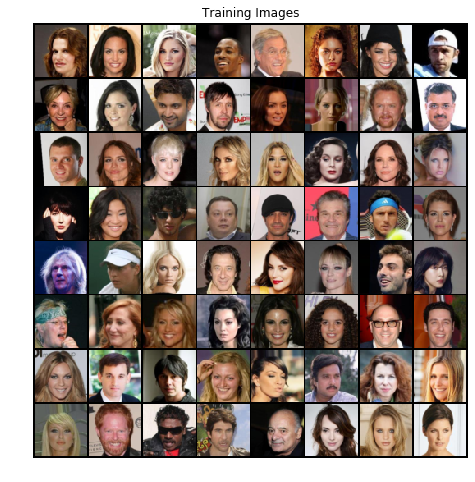

In [80]:
real_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

print(len(data_loader), device)

In [82]:
real_batch[0].size()

torch.Size([512, 3, 64, 64])

In [63]:
%timeit D = DiscNet(in_dim = 3, out_dim = 1, ndf = 64 , ngpu = 1).to(device)

# D.weight_init(mean = 0.0, std = 0.02)
# res = D(Variable(real_batch[0].to(device)))

20.6 ms ± 642 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
%timeit res.view(-1)

2.48 µs ± 15 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [32]:
%timeit Variable(torch.ones(128, device = device))

10.1 µs ± 142 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


9.62 µs ± 223 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
